Grid from sutton, page 163

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
class GridWorld:
    def __init__(self):
        self.player = None
        self._create_grid()
        
    def _create_grid(self):
        self.grid = 20 * np.ones((4, 12))
        self.grid[-1, 1:11] = 0
        self.grid[-1, -1] = 4
        
    def reset(self):
        self.player = (3, 0)        
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        # Rules
        if self.grid[self.player] == 0:
            reward = -100
            done = True
            self.player = (3, 0)
        elif self.grid[self.player] == 4:
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return self.player[0] * 12 + self.player[1]
        
    def render(self):
        assert self.player is not None, 'You first need to call .reset()'
        grid = self.grid.copy()
        grid[self.player] = 8
        
        plt.imshow(grid, cmap='tab20c', interpolation='nearest')
        plt.pause(0.1)

In [18]:
learning_rate = 0.1

In [19]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3

In [20]:
env = GridWorld()

We need a table of values that maps each state-action pair to a value, we'll create such table and initialize all values to zero (or to a random value)

In [6]:
# The number of states in simply the number of "squares" in our grid world, in this case 4 * 12
num_states = 4 * 12
# We have 4 possible actions, up, down, right and left
num_actions = 4

q_values = np.zeros((num_states, num_actions))

In [7]:
df = pd.DataFrame(q_values, columns=[' up ', 'down', 'right', 'left'])
df.index.name = 'States'

In [8]:
df.head()

,up,down,right,left
States,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [9]:
# Maybe talk on why we need exploration?

In [10]:
def egreedy_policy(q_values, state, epsilon=0.1):
    ''' 
    Choose an action based on a epsilon greedy policy.    
    A random action is selected with epsilon probability, else select the best action.    
    '''
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(q_values[state])

In [11]:
q_values = np.zeros((num_states, num_actions))
rewards = []

for _ in range(100):
    ep_rewards = []
    for _ in range(500):
        state = env.reset()    
        done = False
        reward_sum = 0

        while not done:
            # Choose action        
            action = egreedy_policy(q_values, state, 0.1)
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            # Update q_values        
            td_target = reward + np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            # Update state
            state = next_state

        ep_rewards.append(reward_sum)
    
    rewards.append(ep_rewards)

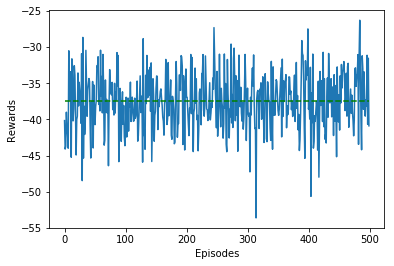

In [12]:
avg_rewards = np.mean(rewards, axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

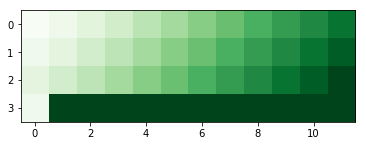

In [13]:
# The agent never gets to take an action on the cliff or in the goal,
# that's why their values are unchanged
plt.imshow(np.max(q_values, axis=1).reshape(4, 12), cmap='Greens')

In [12]:
q_values_sarsa = np.zeros((num_states, num_actions))
rewards = []

for _ in range(100):
    ep_rewards = []
    for _ in range(500):
        state = env.reset()    
        done = False
        reward_sum = 0
        # Choose action        
        action = egreedy_policy(q_values_sarsa, state, 0.1)

        while not done:        
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            
            # Choose next action
            next_action = egreedy_policy(q_values_sarsa, next_state, 0.1)
            # Next q value is the value of the next action
            td_target = reward + q_values_sarsa[next_state][next_action]
            td_error = td_target - q_values_sarsa[state][action]
            # Update q value
            q_values_sarsa[state][action] += learning_rate * td_error

            # Update state and action        
            state = next_state
            action = next_action

        ep_rewards.append(reward_sum)
        
    rewards.append(ep_rewards)

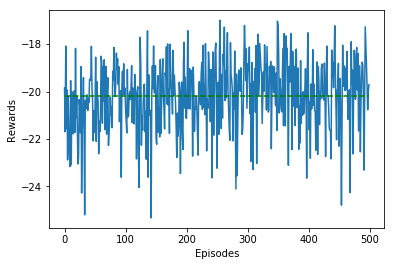

In [15]:
avg_rewards = np.mean(rewards, axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

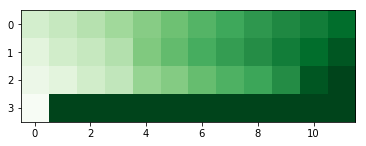

In [27]:
plt.imshow(np.max(q_values_sarsa, axis=1).reshape(4, 12), cmap='Greens')

## Visualization

For visualization to work you have to restart the notebook and run:
`%matplotlib` instead of `%matplotlib inline`

In [1]:
# Restart notebook and run these imports instead of the ones on top
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg


In [13]:
def play(q_values):
    state = env.reset()
    done = False

    while not done:    
        env.render()

        # Select action
        action = egreedy_policy(q_values, state, 0.0)
        # Do the action
        next_state, reward, done = env.step(action)  

        # Update state and action        
        state = next_state    

    env.render()

In [15]:
play(q_values)

In [25]:
play(q_values_sarsa)